In [1]:
!pwd

/home/niranjan/MY-WORLD/DataScience/Code-Repository/Ride-Requests-Time-Series-Forecasting


In [2]:
!ls

Data  README.md  Ride-Requests-TSF-v1.ipynb


# Table of Contents


[1) Requiremnets](#another_cell_1)
<br>
[2) Method-1: ARIMA Forecast](#another_cell_2)
<br>
[3) Method-2: LSTM Forecast](#another_cell_3)
<br>
[4) Method-3: Prophet Forecast](#another_cell_4)
<br>
[5) Further Improvements](#another_cell_5)


In my day-to-day, I encounter time-series related tasks almost every day. The most frequent questions asked are the following: what will happen with our metrics in the next day/week/month/etc., how many user will install our app, how much time will they spend online, how many actions will users complete, and so on. We can approach these prediction tasks using different methods depending on the required quality of the prediction, length of the forecast period, and, of course, the time within which we have to choose features and tune parameters to achieve desired results.

    Time series is a series of data points indexed (or listed or graphed) in time order.

Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.




# 1) Requirements

<a id='another_cell_1'></a>


- Anaconda Distribution
- Python(3.7) and python Packages
    - pmdarima (pip)
    - Keras (pip)
    - Tensorflow (pip)
    - fbprophet ( install using conda)
- Upgrade Plotly package
    - $pip install --upgrade plotly


# 2) Method-1: ARIMA Forecast
<a id='another_cell_2'></a>

We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s) , Seasonal Autoregression Moving Average model:

 - AR(p)  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p . To determine the initial  p , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
 - MA(q)  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q . The initial value can be found on the ACF plot with the same logic as before.
 
 Let's combine our first 4 letters:

AR(p)+MA(q)=ARMA(p,q) 
What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

 - I(d)  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the  ARIMA  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

 - S(s)  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  (P,D,Q) 
 - P  - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P  should be 2.

 - Q  - similar logic using the ACF plot instead.

 - D  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [4]:
rideDataFrame = pd.read_csv("./Data/ride_r.csv", parse_dates=['ts'])

In [5]:
rideDataFrame.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


In [6]:
rideDataFrame.shape

(8381556, 6)

In [7]:
rideDataFrame.isnull().any()

ts          False
number      False
pick_lat    False
pick_lng    False
drop_lat    False
drop_lng    False
dtype: bool

In [8]:
rideDataFrame.dtypes

ts          datetime64[ns]
number              object
pick_lat           float64
pick_lng           float64
drop_lat           float64
drop_lng           float64
dtype: object

In [9]:
rideDataFrame.describe().T

,count,mean,std,min,25%,50%,75%,max
pick_lat,8381556.0,13.010244,0.903278,-48.772170,12.916377,12.937410,12.971180,67.69665
pick_lng,8381556.0,77.628746,0.449090,-93.958590,77.595110,77.615974,77.645150,92.81412
drop_lat,8381556.0,13.010843,0.951646,-57.946835,12.916267,12.938946,12.973074,61.52401
drop_lng,8381556.0,77.607086,1.475269,-127.817890,77.592720,77.617370,77.647060,174.88597


In [10]:
dayRideDataFrame = pd.Series(rideDataFrame.groupby(['ts']).size())
dayRideDataFrame

ts
2018-04-07 01:23:31    1
2018-04-07 01:27:20    1
2018-04-07 01:27:26    1
2018-04-07 01:27:29    1
2018-04-07 01:27:35    1
                      ..
2019-04-07 23:59:37    1
2019-04-07 23:59:39    1
2019-04-07 23:59:46    1
2019-04-07 23:59:53    1
2019-04-07 23:59:59    2
Length: 5889839, dtype: int64

In [11]:
dayRideDataFrame.index = pd.DatetimeIndex(dayRideDataFrame.index)
dayRideDataFrame.index

DatetimeIndex(['2018-04-07 01:23:31', '2018-04-07 01:27:20',
               '2018-04-07 01:27:26', '2018-04-07 01:27:29',
               '2018-04-07 01:27:35', '2018-04-07 01:27:37',
               '2018-04-07 01:27:40', '2018-04-07 01:27:43',
               '2018-04-07 01:27:45', '2018-04-07 01:27:55',
               ...
               '2019-04-07 23:59:24', '2019-04-07 23:59:28',
               '2019-04-07 23:59:30', '2019-04-07 23:59:33',
               '2019-04-07 23:59:35', '2019-04-07 23:59:37',
               '2019-04-07 23:59:39', '2019-04-07 23:59:46',
               '2019-04-07 23:59:53', '2019-04-07 23:59:59'],
              dtype='datetime64[ns]', name='ts', length=5889839, freq=None)

In [12]:
dayRideDataFrame = dayRideDataFrame.resample('D').apply(np.sum)
dayRideDataFrame.head()

ts
2018-04-07     9375
2018-04-08     5716
2018-04-09    11552
2018-04-10    11186
2018-04-11    12129
Freq: D, dtype: int64

In [13]:
df = pd.DataFrame(dayRideDataFrame).reset_index()
df.columns = ['Day', 'Requests']
df.head()

,Day,Requests
0,2018-04-07,9375
1,2018-04-08,5716
2,2018-04-09,11552
3,2018-04-10,11186
4,2018-04-11,12129


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
Day         366 non-null datetime64[ns]
Requests    366 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [15]:
df.Day = pd.to_datetime(df.Day)
df = df.set_index("Day")

df.head()


,Requests
Day,
2018-04-07,9375
2018-04-08,5716
2018-04-09,11552
2018-04-10,11186
2018-04-11,12129


In [16]:
df.index.freq = 'D'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2018-04-07 to 2019-04-07
Freq: D
Data columns (total 1 columns):
Requests    366 non-null int64
dtypes: int64(1)
memory usage: 5.7 KB


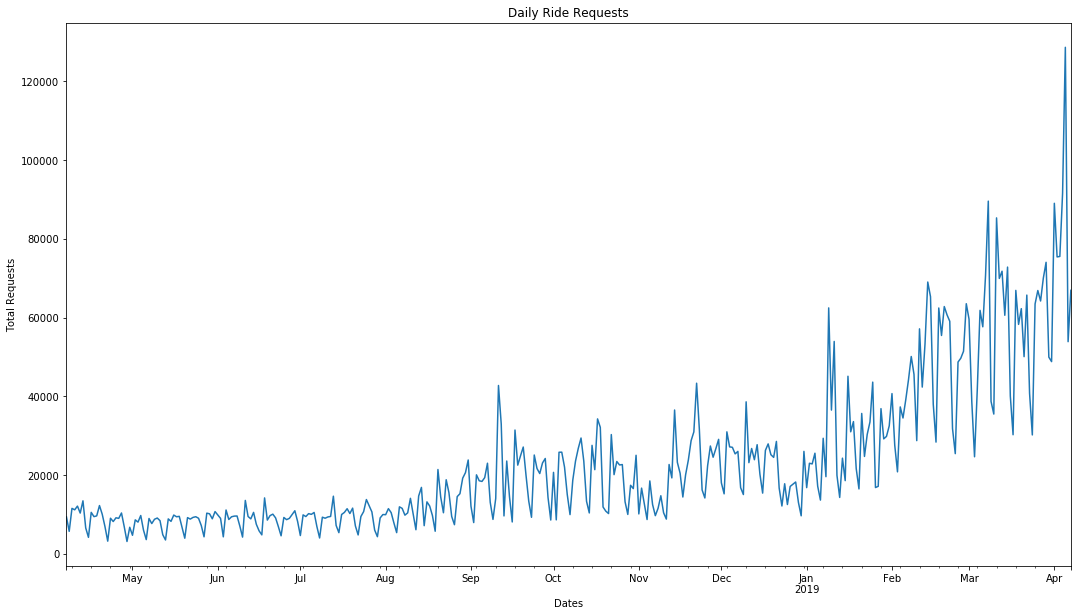

In [17]:
ax = df['Requests'].plot(figsize = (18,10), title = "Daily Ride Requests")
ax.set(xlabel='Dates', ylabel='Total Requests');

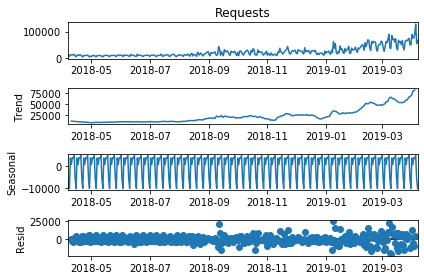

In [18]:
a = seasonal_decompose(df["Requests"], model = "add")
a.plot();

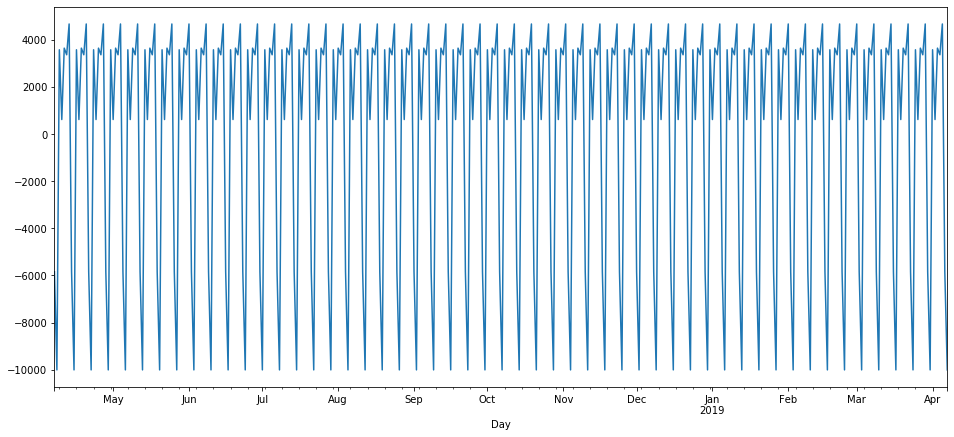

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [20]:
auto_arima(df['Requests'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  366
Model:             SARIMAX(6, 1, 4)x(3, 0, [1], 12)   Log Likelihood               -3751.456
Date:                              Wed, 29 Jan 2020   AIC                           7534.911
Time:                                      21:35:14   BIC                           7597.309
Sample:                                           0   HQIC                          7559.709
                                              - 366                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    760.0445    620.602      1.225      0.221    -456.314    1976.403
ar.L1         -0.9519      0.060    -15.954      0.000      -1.069      -0.835
ar.L2         -0.8583      0.069    -12.517      0.000      -0.993      -0.724
ar.L3         -0.9036      0.049    -18.506      0.000      -0.999      -0.808
ar.L4         -0.9268      0.044    -21.271      0.000      -1.012      -0.841
ar.L5         -0.8333      0.040    -20.741      0.000      -0.912      -0.755
ar.L6         -0.7419      0.039    -19.031      0.000      -0.818      -0.665
ma.L1          0.2163      0.068      3.184      0.001       0.083       0.349
ma.L2          0.0124      0.073      0.169      0.866      -0.131       0.156
ma.L3          0.2703      0.079      3.400      0.001       0.114       0.426
ma.L4          0.2509      0.089      2.832      0.005       0.077       0.425
ar.S.L12       0.3339      0.263      1.271      0.204      -0.181       0.849
ar.S.L24       0.1378      0.074      1.859      0.063      -0.007       0.283
ar.S.L36       0.1397      0.068      2.059      0.040       0.007       0.273
ma.S.L12      -0.5256      0.266     -1.974      0.048      -1.048      -0.004
sigma2      5.296e+07      0.029    1.8e+09      0.000     5.3e+07     5.3e+07
===================================================================================
Ljung-Box (Q):                       62.98   Jarque-Bera (JB):              1655.87
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              23.79   Skew:                             1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+24. Standard errors may be unstable.
"""

In [21]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]
arima_model = SARIMAX(train_data['Requests'], order = (6,1,4), seasonal_order = (3,0,1,12))
arima_result = arima_model.fit()
arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Requests   No. Observations:                  354
Model:             SARIMAX(6, 1, 4)x(3, 0, [1], 12)   Log Likelihood               -3592.982
Date:                              Wed, 29 Jan 2020   AIC                           7215.964
Time:                                      21:42:17   BIC                           7273.961
Sample:                                  04-07-2018   HQIC                          7239.042
                                       - 03-26-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9150      0.058    -15.868      0.000      -1.028      -0.802
ar.L2         -0.8391      0.061    -13.665      0.000      -0.959      -0.719
ar.L3         -0.9107      0.047    -19.203      0.000      -1.004      -0.818
ar.L4         -0.9491      0.048    -19.797      0.000      -1.043      -0.855
ar.L5         -0.8087      0.043    -18.966      0.000      -0.892      -0.725
ar.L6         -0.7229      0.043    -16.787      0.000      -0.807      -0.638
ma.L1          0.2027      0.077      2.641      0.008       0.052       0.353
ma.L2          0.0333      0.069      0.482      0.630      -0.102       0.169
ma.L3          0.2591      0.074      3.523      0.000       0.115       0.403
ma.L4          0.2025      0.084      2.422      0.015       0.039       0.366
ar.S.L12       0.6058      0.135      4.475      0.000       0.340       0.871
ar.S.L24       0.1562      0.072      2.154      0.031       0.014       0.298
ar.S.L36       0.1217      0.064      1.895      0.058      -0.004       0.248
ma.S.L12      -0.8087      0.137     -5.915      0.000      -1.077      -0.541
sigma2      4.361e+07   5.14e-09   8.48e+15      0.000    4.36e+07    4.36e+07
===================================================================================
Ljung-Box (Q):                       54.08   Jarque-Bera (JB):               910.05
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):              22.90   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+31. Standard errors may be unstable.
"""

In [22]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2019-03-27    68013.969299
2019-03-28    55790.852330
2019-03-29    62775.106183
2019-03-30    45495.166203
2019-03-31    39627.288048
2019-04-01    63446.430769
2019-04-02    67012.906468
2019-04-03    72691.098748
2019-04-04    58129.627878
2019-04-05    60218.417211
2019-04-06    47515.888432
2019-04-07    46261.093679
Freq: D, Name: ARIMA Predictions, dtype: float64

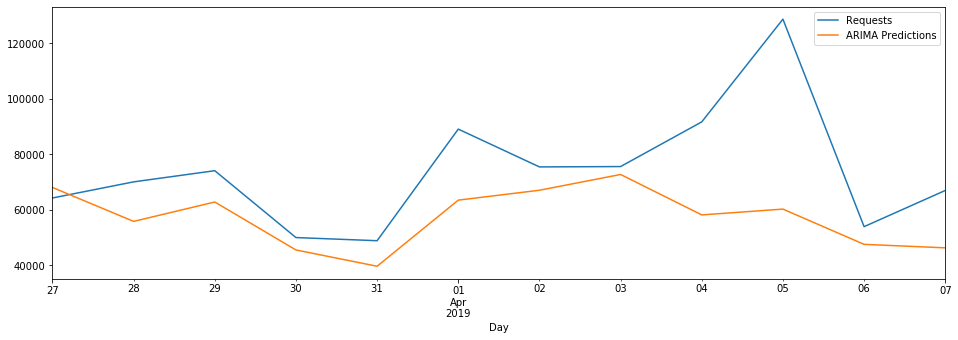

In [23]:
test_data['Requests'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [24]:
arima_rmse_error = rmse(test_data['Requests'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Requests'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 621645431.0891746
RMSE Error: 24932.81835431315
Mean: 22900.426229508197


In [25]:
test_data['ARIMA_Predictions'] = arima_pred
test_data

,Requests,ARIMA_Predictions
Day,,
2019-03-27,64228,68013.969299
2019-03-28,70033,55790.852330
2019-03-29,74056,62775.106183
2019-03-30,49963,45495.166203
2019-03-31,48830,39627.288048
2019-04-01,89044,63446.430769
2019-04-02,75422,67012.906468
2019-04-03,75547,72691.098748
2019-04-04,91651,58129.627878


# 3) Method-2: LSTM Forecast
<a id='another_cell_3'></a>

LSTM stands for long short term memory. It is a model or architecture that extends the memory of recurrent neural networks. Typically, recurrent neural networks have ‘short term memory’ in that they use persistent previous information to be used in the current neural network. Essentially, the previous information is used in the present task. That means we do not have a list of all of the previous information available for the neural node. LSTM introduces long-term memory into recurrent neural networks. It mitigates the vanishing gradient problem, which is where the neural network stops learning because the updates to the various weights within a given neural network become smaller and smaller. It does this by using a series of ‘gates’. These are contained in memory blocks which are connected through layers, like this:
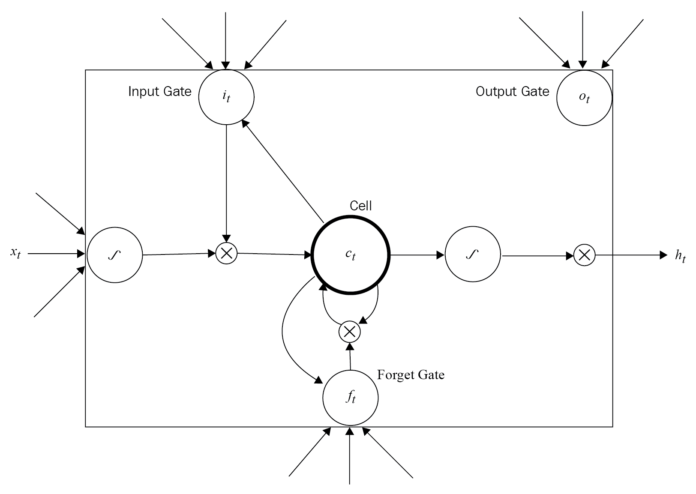


LSTM work There are three types of gates within a unit: Input Gate: Scales input to cell (write) Output Gate: Scales output to cell (read) Forget Gate: Scales old cell value (reset) Each gate is like a switch that controls the read/write, thus incorporating the long-term memory function into the model.


In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [27]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
lstm_model.fit_generator(generator,epochs=90)

Epoch 1/90
342/342 [==============================] - 5s 14ms/step - loss: 0.0180
Epoch 2/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0120
Epoch 3/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0136
Epoch 4/90
342/342 [==============================] - 4s 11ms/step - loss: 0.0128
Epoch 5/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0119
Epoch 6/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0119
Epoch 7/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0120
Epoch 8/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0119
Epoch 9/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0120
Epoch 10/90
342/342 [==============================] - 4s 10ms/step - loss: 0.0111
Epoch 11/90
342/342 [==============================] - 4s 11ms/step - loss: 0.0113
Epoch 12/90
342/342 [==============================] - 4s 11ms/step - loss: 0.0104
Epoch 13/90
3

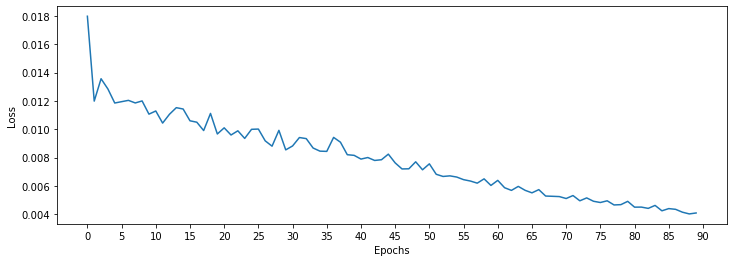

In [29]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,91,5))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [30]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [31]:
lstm_predictions_scaled

[array([0.63870895], dtype=float32),
 array([0.6389961], dtype=float32),
 array([0.5929183], dtype=float32),
 array([0.3726592], dtype=float32),
 array([0.34469247], dtype=float32),
 array([0.5852034], dtype=float32),
 array([0.59823877], dtype=float32),
 array([0.60870594], dtype=float32),
 array([0.6268449], dtype=float32),
 array([0.5916482], dtype=float32),
 array([0.37666124], dtype=float32),
 array([0.35551476], dtype=float32)]

In [32]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[58358.3047756 ],
       [58383.1319313 ],
       [54399.56378305],
       [35357.50637007],
       [32939.69799161],
       [53732.59033513],
       [54859.53605372],
       [55764.45444602],
       [57332.62066698],
       [54289.76365149],
       [35703.49427289],
       [33875.31796002]])

In [33]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data


,Requests,ARIMA_Predictions,LSTM_Predictions
Day,,,
2019-03-27,64228,68013.969299,58358.304776
2019-03-28,70033,55790.852330,58383.131931
2019-03-29,74056,62775.106183,54399.563783
2019-03-30,49963,45495.166203,35357.506370
2019-03-31,48830,39627.288048,32939.697992
2019-04-01,89044,63446.430769,53732.590335
2019-04-02,75422,67012.906468,54859.536054
2019-04-03,75547,72691.098748,55764.454446
2019-04-04,91651,58129.627878,57332.620667


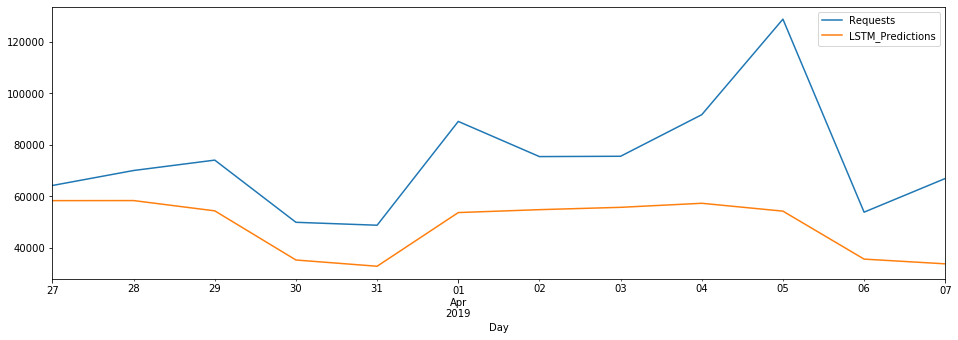

In [34]:
test_data['Requests'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [35]:
lstm_rmse_error = rmse(test_data['Requests'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Requests'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 934701914.130421
RMSE Error: 30572.89508912136
Mean: 22900.426229508197


# 4) Method-3: Prophet Forecast
<a id='another_cell_4'></a>

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [36]:
from fbprophet import Prophet

In [37]:
df.head()

,Requests
Day,
2018-04-07,9375
2018-04-08,5716
2018-04-09,11552
2018-04-10,11186
2018-04-11,12129


In [38]:
df_pr = df.copy()
df_pr = df.reset_index()
df_pr.columns = ['ds','y'] 
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]
from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12)
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
361,2019-04-03,63057.358049,57930.747663,75486.424377,63005.963827,63112.685440,3758.889475,3758.889475,3758.889475,3758.889475,3758.889475,3758.889475,0.0,0.0,0.0,66816.247524
362,2019-04-04,63469.746201,57876.402888,74726.399177,63401.147948,63540.364859,3055.637728,3055.637728,3055.637728,3055.637728,3055.637728,3055.637728,0.0,0.0,0.0,66525.383930
363,2019-04-05,63882.134353,59319.004995,77154.687704,63794.426462,63966.991521,4480.920157,4480.920157,4480.920157,4480.920157,4480.920157,4480.920157,0.0,0.0,0.0,68363.054510
364,2019-04-06,64294.522505,50500.852058,68465.346842,64193.067688,64393.722160,-5540.098424,-5540.098424,-5540.098424,-5540.098424,-5540.098424,-5540.098424,0.0,0.0,0.0,58754.424082
365,2019-04-07,64706.910658,46643.994293,63967.997647,64587.622285,64826.142893,-9718.633915,-9718.633915,-9718.633915,-9718.633915,-9718.633915,-9718.633915,0.0,0.0,0.0,54988.276743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


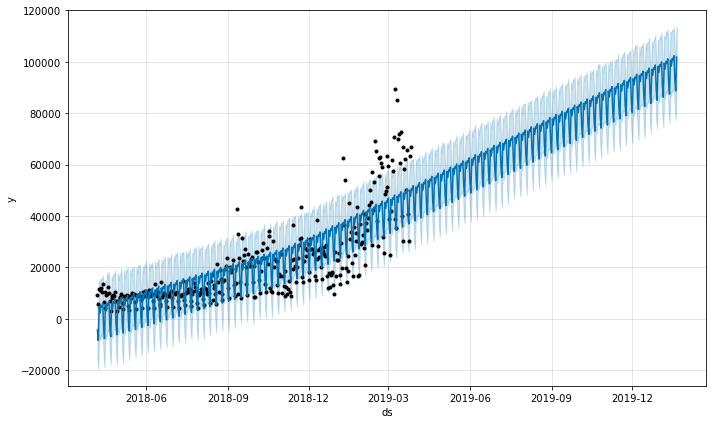

In [39]:
m1 = Prophet(changepoint_prior_scale=0.01).fit(train_data_pr)
future1 = m1.make_future_dataframe(periods=300, freq='D')
fcst1 = m1.predict(future1)
fig1 = m1.plot(fcst1)

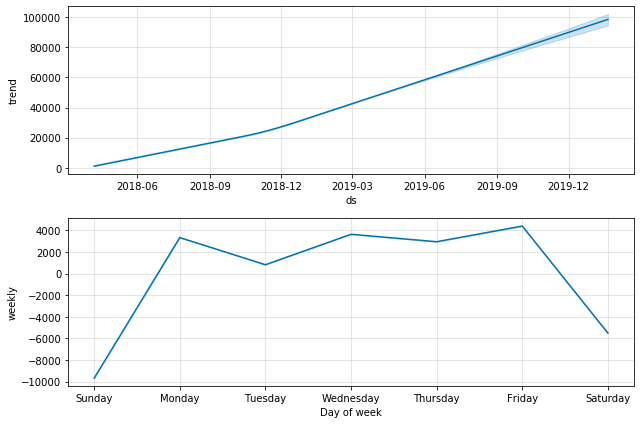

In [40]:
fig2_1 = m1.plot_components(fcst1)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


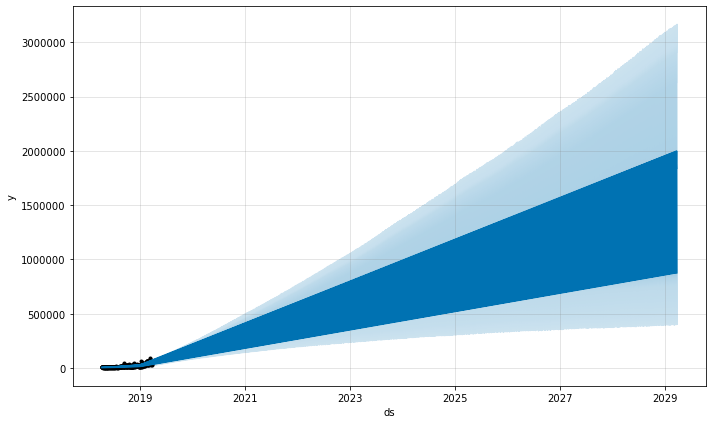

In [41]:
m2 = Prophet(seasonality_mode='multiplicative').fit(train_data_pr)
future2 = m2.make_future_dataframe(periods=3652)
fcst2 = m2.predict(future2)
fig1_2 = m.plot(fcst2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


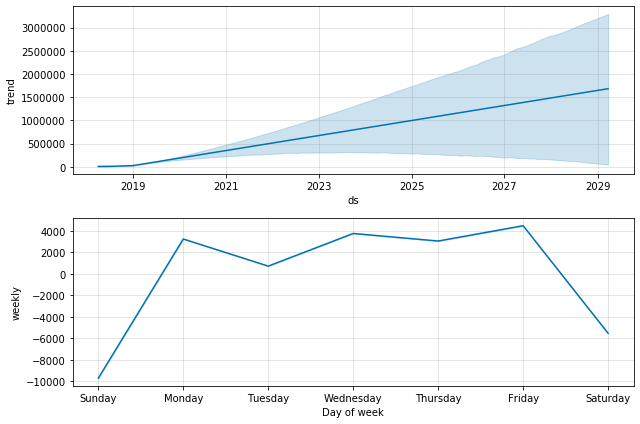

In [42]:
m3 = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(train_data_pr)
fcst3 = m3.predict(future2)
fig1_3 = m.plot_components(fcst3)

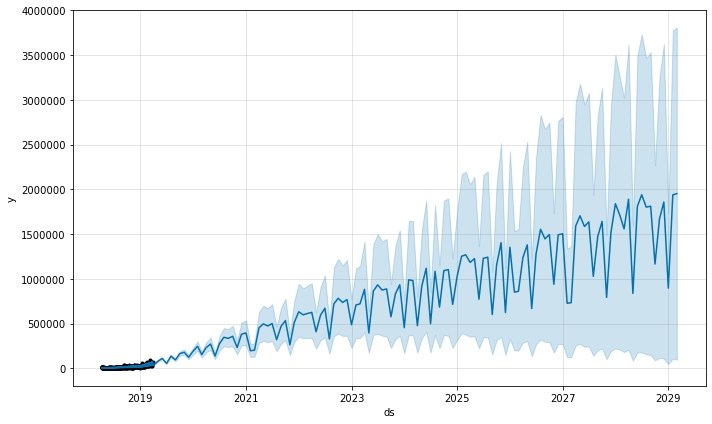

In [43]:
future3 = m3.make_future_dataframe(periods=120, freq='M')
fcst3 = m3.predict(future3)
fig1_3_1 = m3.plot(fcst3)

In [44]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "D"
prophet_pred

,Pred
Date,
2019-03-27,63929.530459
2019-03-28,63638.666865
2019-03-29,65476.337446
2019-03-30,55867.707017
2019-03-31,52101.559678
2019-04-01,65477.638412
2019-04-02,63363.198208
2019-04-03,66816.247524
2019-04-04,66525.383930


In [45]:
import matplotlib.pyplot as plt

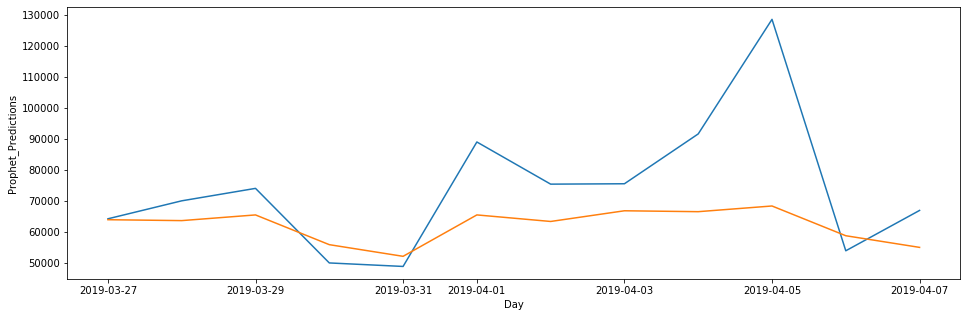

In [46]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Requests"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [47]:
prophet_rmse_error = rmse(test_data['Requests'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Requests'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 447590575.1212592
RMSE Error: 21156.33652410689
Mean: 22900.426229508197


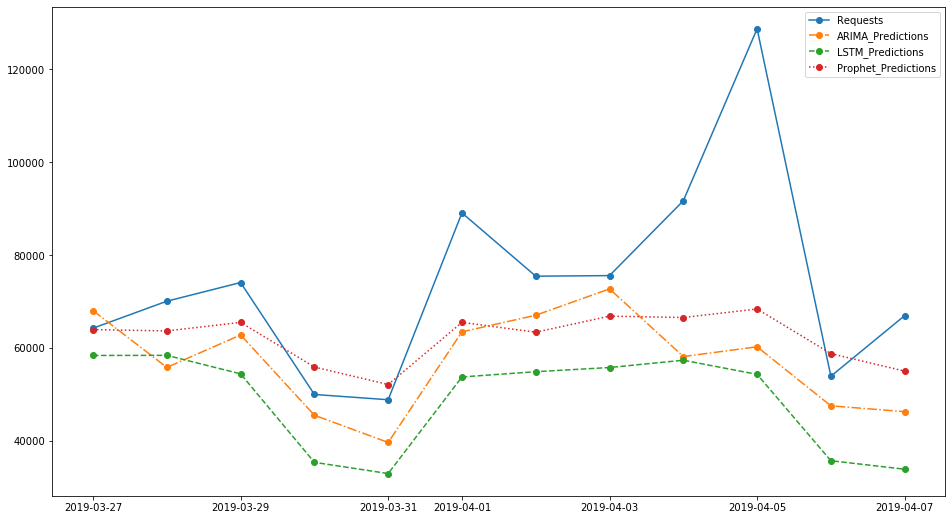

In [48]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))


plt1, = plt.plot_date(test_data.index, test_data["Requests"], linestyle="-",label='Requests')
plt2, = plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.",label='ARIMA_Predictions')
plt3, = plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--",label='LSTM_Predictions')
plt4, = plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":",label='Prophet_Predictions')

plt.legend(handles=[plt1,plt2,plt3,plt4])


In [49]:
print(f"Mean: {test_data['Requests'].mean()}")
errors


Mean: 74021.91666666667


,Models,RMSE Errors,MSE Errors
0,ARIMA,24932.818354,6.216454e+08
1,LSTM,30572.895089,9.347019e+08
2,Prophet,21156.336524,4.475906e+08


In [50]:
test_data

,Requests,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Day,,,,
2019-03-27,64228,68013.969299,58358.304776,63929.530459
2019-03-28,70033,55790.852330,58383.131931,63638.666865
2019-03-29,74056,62775.106183,54399.563783,65476.337446
2019-03-30,49963,45495.166203,35357.506370,55867.707017
2019-03-31,48830,39627.288048,32939.697992,52101.559678
2019-04-01,89044,63446.430769,53732.590335,65477.638412
2019-04-02,75422,67012.906468,54859.536054,63363.198208
2019-04-03,75547,72691.098748,55764.454446,66816.247524
2019-04-04,91651,58129.627878,57332.620667,66525.383930


# 5) Further Improvements
<a id='another_cell_5'></a>

 - Finally we have a forecast at the original scale. Not a very good forecast I would say but you got the idea right? Now, we can refine the methodology further and make a better solution.